https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df

#Preprocess Data

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import os
import math
import re

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import sentencepiece
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


In [ ]:
train = pd.read_csv(r"https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/train_text_emoji_clean.csv")
test = pd.read_csv(r"https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/test_text_emoji_clean.csv")
valid = pd.read_csv(r"https://raw.githubusercontent.com/RussellDash332/CS3244-Twemoji/main/Datasets/valid_text_emoji_clean.csv")

In [ ]:
def to_columns(label):
    if i == label:
        return 1
    else:
        return 0

In [ ]:
for i in range(12):
    train[i] = train['labels'].apply(to_columns)
    test[i] = test['labels'].apply(to_columns)
    valid[i] = valid['labels'].apply(to_columns)

In [ ]:
train = train.drop("labels", axis = 1)
test = test.drop("labels", axis = 1)
valid = valid.drop("labels", axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


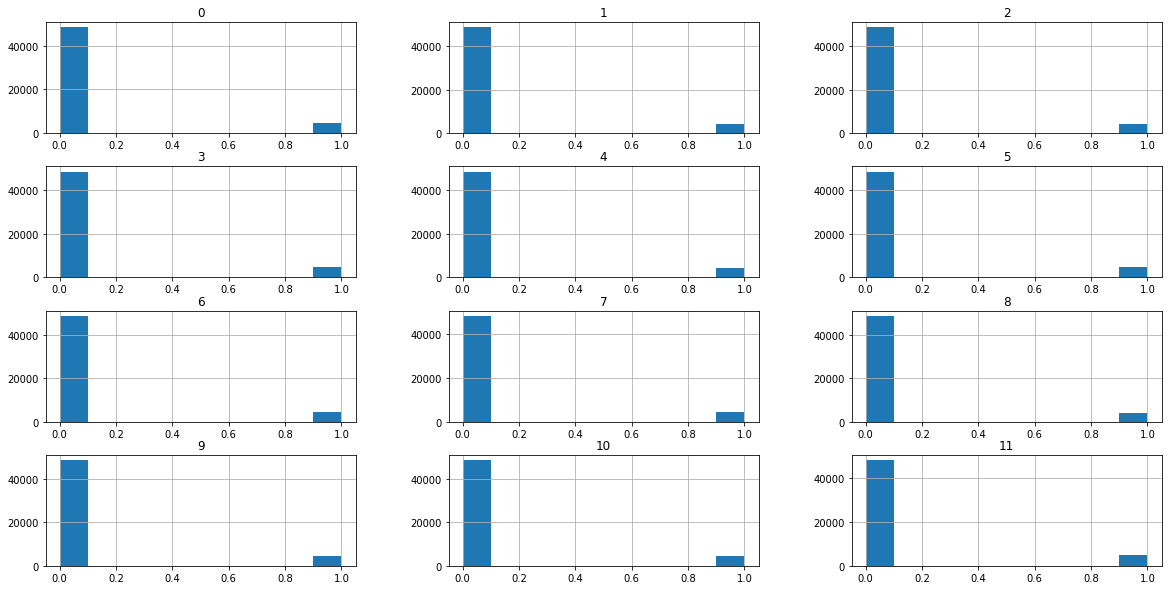

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10));
train[range(12)].hist(ax=ax);

In [ ]:
import spacy

nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
sentence = "The striped bats are hanging on their feet for best"

# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])
#> 'the strip bat be hang on -PRON- foot for good'

'the stripe bat be hang on -PRON- foot for good'

In [ ]:
def preprocess_text(sen):
    sentence = nlp(sen)
    sentence = " ".join([token.lemma_ for token in sentence])

    sentence = re.sub("-PRON-", "", sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = sentence.lower()

    return sentence.strip()

In [ ]:
print(preprocess_text("I've known that you could've done something better than this-- ''' :)) THEY ARE called AppLes fruits oranges can't you see?"))
print(preprocess_text("I'll go there in a few seconds.. don't wait for me"))
print(preprocess_text("better best"))
print(preprocess_text("what's the point?"))

have know that could have do something well than this they are call apples fruit orange can not see
will go there in a few second do not wait for
better best
what be the point


In [ ]:
train["tweets"] = train["tweets"].apply(preprocess_text)
test["tweets"] = test["tweets"].apply(preprocess_text)
valid["tweets"] = valid["tweets"].apply(preprocess_text)

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Tweets Embeddings");
    ax.set_ylabel("Number of Tweets");
    return

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", do_lower_case=True)
tokenizer("Don't you love 🤗 Transformers? We sure do.", return_tensors = "pt")

train_text_list = train["tweets"].values
test_text_list = test["tweets"].values
valid_text_list = valid["tweets"].values

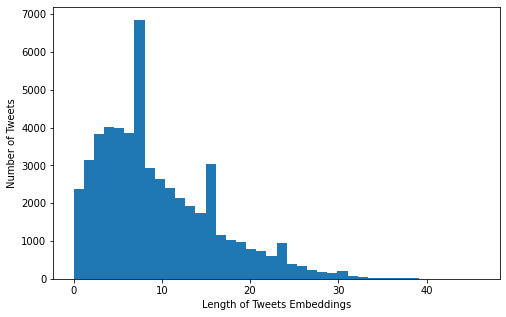

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

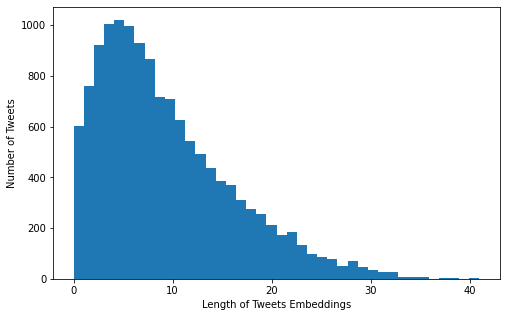

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=31) # since most of the tweets have less than 40 sub-words
print(train_input_ids)
print(train_input_ids[0])

[[  297    39   102 ...     0     0     0]
 [   17 18535    47 ...     0     0     0]
 [   39 24361    93 ...     0     0     0]
 ...
 [11752 22268   112 ...     0     0     0]
 [  805 16395    44 ...     0     0     0]
 [  112    50    39 ...     0     0     0]]
[ 297   39  102 1127   17  155 7290    4    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
print(tokenizer.decode([297, 39, 102, 1127, 17, 155, 1284, 180, 7290, 4, 3]))
print(tokenizer.decode([4, 3, 4, 3]))

school be so dead o pron god<sep><cls>
<sep><cls><sep><cls>


In [ ]:
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=31) # since most of the tweets have less than 50 sub-words
print(test_input_ids)
print(test_input_ids[0])

[[   18  3580    39 ...     0     0     0]
 [11508    39   830 ...     0     0     0]
 [   17   150    64 ...     0     0     0]
 ...
 [   17   150   112 ...     0     0     0]
 [  338  1816    48 ...     0     0     0]
 [ 5422   171   129 ...     0     0     0]]
[  18 3580   39  102 1429   17  150  197   17 4925  529 7144    4    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [ ]:
valid_input_ids = tokenize_inputs(valid_text_list, tokenizer, num_embeddings=31) # since most of the tweets have less than 50 sub-words
print(valid_input_ids)
print(valid_input_ids[0])

[[   17 11709 16247 ...     0     0     0]
 [   39  1127     4 ...     0     0     0]
 [ 2514  1615    18 ...     0     0     0]
 ...
 [ 4489   125   759 ...     0     0     0]
 [   71   166  1620 ...     0     0     0]
 [   17   150   564 ...     0     0     0]]
[   17 11709 16247  2035  6231    76     4     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks
    
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)
valid_attention_masks = create_attn_masks(valid_input_ids)

In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

In [ ]:
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
valid["features"] = valid_input_ids.tolist()
valid["masks"] = valid_attention_masks

In [ ]:
train

,annotations,tweets,0,1,2,3,4,5,6,7,8,9,10,11,features,masks
0,😂,school be so dead o god,1,0,0,0,0,0,0,0,0,0,0,0,"[297, 39, 102, 1127, 17, 155, 7290, 4, 3, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,😂,lol have be tell be bad than but i do not beli...,1,0,0,0,0,0,0,0,0,0,0,0,"[17, 18535, 47, 39, 759, 39, 948, 100, 57, 17,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,😂,be excite to hear that shit be go rattle soul,1,0,0,0,0,0,0,0,0,0,0,0,"[39, 24361, 93, 22, 1388, 29, 7341, 39, 216, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,😂,damn alicia know everything even indirect tweet,1,0,0,0,0,0,0,0,0,0,0,0,"[7757, 1296, 25360, 175, 931, 176, 16094, 1929...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,😂,that sound like everything,1,0,0,0,0,0,0,0,0,0,0,0,"[29, 1224, 115, 931, 4, 3, 0, 0, 0, 0, 0, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52879,🙃,or that picture be just cute to,0,0,0,0,0,0,0,0,0,0,0,1,"[49, 29, 1986, 39, 125, 10920, 22, 4, 3, 0, 0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
52880,🙃,be tow wit some gas still hate,0,0,0,0,0,0,0,0,0,0,0,1,"[39, 22, 694, 16395, 106, 1256, 194, 4177, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
52881,🙃,yeah kinda do,0,0,0,0,0,0,0,0,0,0,0,1,"[11752, 22268, 112, 4, 3, 0, 0, 0, 0, 0, 0, 0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
52882,🙃,nothing wit youuuu raymundo,0,0,0,0,0,0,0,0,0,0,0,1,"[805, 16395, 44, 660, 660, 660, 17, 2563, 98, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = range(12)
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [ ]:
Y_test = test[label_cols].values.tolist()

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

# Model Building

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

## Model Training

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
num_epochs=7

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "xlnet_tweets.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

# Model overfits when epoch >=3, but more number of correct predictions for test data compared to epoch = 2
# Epoch:   0%|          | 0/5 [00:00<?, ?it/s]Train loss: 0.01796796278462626
# Valid loss: 0.017568994314693265
# Epoch:  20%|██        | 1/5 [25:29<1:41:59, 1529.99s/it]Saving model at epoch 0 with validation loss of 0.017568994314693265


# Train loss: 0.016354909224060857
# Valid loss: 0.016553795436609904
# Epoch:  40%|████      | 2/5 [51:01<1:16:33, 1531.01s/it]Saving model at epoch 1 with validation loss of 0.016553795436609904


# Train loss: 0.015297270020661714
# Epoch:  60%|██████    | 3/5 [1:16:25<50:55, 1527.55s/it]Valid loss: 0.0169240757001789


# Train loss: 0.01408364675511861
# Epoch:  80%|████████  | 4/5 [1:41:53<25:27, 1527.79s/it]Valid loss: 0.017551086031044796


# Train loss: 0.012696515599432199
# Epoch: 100%|██████████| 5/5 [2:07:19<00:00, 1527.87s/it]Valid loss: 0.018607749649668708

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Train loss: 0.008732781574669932
Valid loss: 0.008485114984073375


Epoch:  14%|█▍        | 1/7 [13:09<1:18:58, 789.71s/it]

Saving model at epoch 0 with validation loss of 0.008485114984073375


Train loss: 0.007933024304064687
Valid loss: 0.007711087938462509


Epoch:  29%|██▊       | 2/7 [26:17<1:05:41, 788.34s/it]

Saving model at epoch 1 with validation loss of 0.007711087938462509


Train loss: 0.007486590551066332


Epoch:  43%|████▎     | 3/7 [39:19<52:23, 785.82s/it]  

Valid loss: 0.007816424204938693


Train loss: 0.007091111253399539


Epoch:  57%|█████▋    | 4/7 [52:22<39:13, 784.50s/it]

Valid loss: 0.008010660856575333


Train loss: 0.006620362956378637


Epoch:  71%|███████▏  | 5/7 [1:05:24<26:07, 783.75s/it]

Valid loss: 0.008250404313714026


Train loss: 0.006102429197240494


Epoch:  86%|████████▌ | 6/7 [1:18:34<13:05, 785.75s/it]

Valid loss: 0.00872923785059435


Train loss: 0.0055558715004660735


Epoch: 100%|██████████| 7/7 [1:31:44<00:00, 786.34s/it]

Valid loss: 0.009352353171224844




Text(0.5, 1.0, 'Loss vs Number of Epochs')

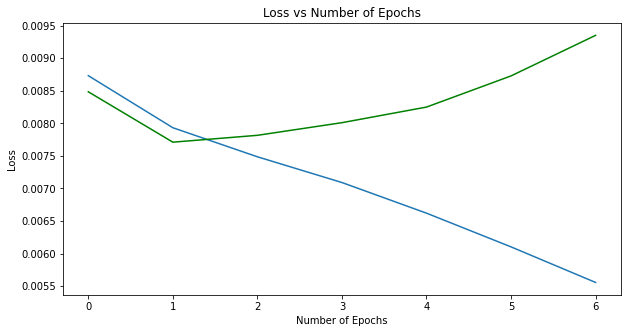

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Get Predictions

In [ ]:
# cwd = os.getcwd()
# model_save_path = output_model_file = os.path.join(cwd, "xlnet_tweets.bin")
# model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
# model = model.eval()

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.02958536e-01, 6.47765160e-01, 3.25229950e-02, ...,
        4.47309692e-04, 2.30057049e-04, 1.25071257e-02],
       [2.89852172e-01, 1.17401555e-01, 9.93184093e-03, ...,
        4.44879949e-01, 6.97182342e-02, 7.69844353e-02],
       [3.45544107e-02, 4.23822820e-01, 6.08724542e-02, ...,
        4.43179011e-02, 1.14077460e-02, 6.66763335e-02],
       ...,
       [7.17747748e-01, 2.69745857e-01, 7.64435797e-04, ...,
        1.96924433e-03, 7.12163281e-04, 1.91143025e-02],
       [3.47794453e-03, 1.91507686e-03, 2.03420204e-04, ...,
        2.79090041e-03, 1.18797168e-03, 4.39668804e-01],
       [3.73856612e-02, 1.46435993e-02, 2.45874114e-02, ...,
        1.97567895e-01, 7.00027883e-01, 2.12773196e-02]])

In [ ]:
# Y_test

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_class = np.argmax(pred_probs,axis=1)
y_test_class = np.argmax(Y_test, axis=1)
conf = confusion_matrix(y_test_class, y_pred_class)

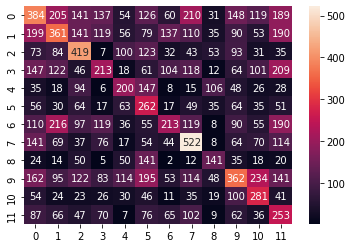

In [ ]:
import seaborn as sns

sns.heatmap(conf, annot=True, fmt="d")

In [ ]:
trace = np.trace(conf)

print("\nTrace of given 12x12 matrix:")
print(trace)
print(trace/np.sum(conf))


Trace of given 12x12 matrix:
3611
0.26777901371894697


In [ ]:
test_to_csv = test.reset_index()

In [ ]:
label_cols = [range(12)]

for i in range(12):
    test_to_csv[i] = pred_probs[:, i]

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "tweets_5_epoch_before_rounding.csv")
test_to_csv[list(range(12))].to_csv(pred_save_path, index=False)

In [ ]:
pred_probs = np.round(pred_probs)

for i in range(12):
    test_to_csv[i] = pred_probs[:, i]

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "tweets_5_epoch_after_rounding.csv")
test_to_csv[list(range(12))].to_csv(pred_save_path, index=False)

## Ignore This

In [ ]:
cwd = os.getcwd()
test_prediction = pd.read_csv(os.path.join(cwd, "tweets_5_epoch_after_rounding.csv"))

In [ ]:
test_prediction

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13480,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13483,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


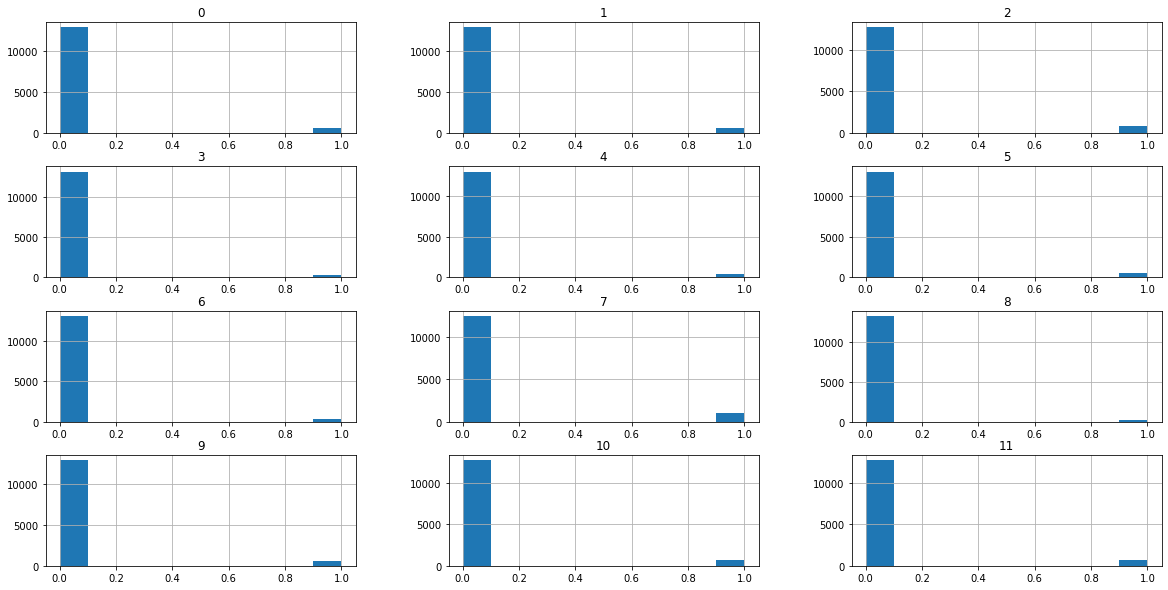

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10));
test_prediction[list(str(x) for x in range(12))].hist(ax=ax);

In [ ]:
count = 0
index=[]
for i in range(len(test)):
    same = True
    for j in range(12):
        if int(test.iloc[i,2+j]) != int(test_prediction.iloc[i, j]):
            same = False
        if i==1:
            print(test.iloc[i,2+j])
            print(test_prediction.iloc[i,j])
    if same:
        index+=[i]
        count+=1

1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0


In [ ]:
count

2299

In [ ]:
test.iloc[index]

,annotations,tweets,0,1,2,3,4,5,6,7,8,9,10,11,features,masks
16,😂,lao if i ever take a nap with pant on always e...,1,0,0,0,0,0,0,0,0,0,0,0,"[2483, 155, 108, 17, 150, 545, 182, 24, 17, 12...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
44,😂,how many more time will make a fool of hilario...,1,0,0,0,0,0,0,0,0,0,0,0,"[160, 142, 70, 92, 53, 144, 24, 8956, 20, 2426...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
48,😂,during the rain delay have a dance off shit be...,1,0,0,0,0,0,0,0,0,0,0,0,"[181, 18, 2655, 4598, 47, 24, 2724, 177, 7341,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
50,😂,hahaha football player la,1,0,0,0,0,0,0,0,0,0,0,0,"[17, 11709, 16247, 1288, 928, 2483, 4, 3, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
70,😂,no not that s plug,1,0,0,0,0,0,0,0,0,0,0,0,"[116, 50, 29, 17, 23, 7943, 4, 3, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13465,🙃,be leave to tahoe in hour and i do not even ha...,0,0,0,0,0,0,0,0,0,0,0,1,"[39, 755, 22, 17, 751, 10579, 25, 1671, 21, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13474,🙃,guess ill make this drive,0,0,0,0,0,0,0,0,0,0,0,1,"[3132, 4195, 144, 52, 1323, 4, 3, 0, 0, 0, 0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ..."
13476,🙃,here come the pregnancy police because i have ...,0,0,0,0,0,0,0,0,0,0,0,1,"[193, 280, 18, 7532, 365, 149, 17, 150, 47, 24...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13477,🙃,have work every other day be not that bad i guess,0,0,0,0,0,0,0,0,0,0,0,1,"[47, 154, 300, 86, 191, 39, 50, 29, 948, 17, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test_prediction.iloc[index]

,0,1,2,3,4,5,6,7,8,9,10,11
16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
count1 = 0
index1=[]
for i in range(len(test)):
    isone = False
    for j in range(12):
        if int(test_prediction.iloc[i, j]) !=0:
            isone = True
    if isone:
        index1+=[i]
        count1+=1

In [ ]:
count1

6823

In [ ]:
test.iloc[index1]

,annotations,tweets,0,1,2,3,4,5,6,7,8,9,10,11,features,masks
0,😂,the conversation be so deep i see adele rolling,1,0,0,0,0,0,0,0,0,0,0,0,"[18, 3580, 39, 102, 1429, 17, 150, 197, 17, 49...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,😂,what s bracken,1,0,0,0,0,0,0,0,0,0,0,0,"[113, 17, 23, 6700, 16014, 4, 3, 0, 0, 0, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ..."
10,😂,i watch that shit so many time,1,0,0,0,0,0,0,0,0,0,0,0,"[17, 150, 1628, 29, 7341, 102, 142, 92, 4, 3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
12,😂,lebron be trash lead all player in point rebou...,1,0,0,0,0,0,0,0,0,0,0,0,"[17, 529, 2369, 253, 39, 10247, 575, 71, 928, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
16,😂,lao if i ever take a nap with pant on always e...,1,0,0,0,0,0,0,0,0,0,0,0,"[2483, 155, 108, 17, 150, 545, 182, 24, 17, 12...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,🙃,the ball hate croatia suh,0,0,0,0,0,0,0,0,0,0,0,1,"[18, 1657, 4177, 17, 4736, 4807, 101, 17, 23, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13481,🙃,sexy bitch i hope bout,0,0,0,0,0,0,0,0,0,0,0,1,"[12187, 15683, 17, 150, 937, 12108, 4, 3, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
13482,🙃,i do not realize that tweet be private and no ...,0,0,0,0,0,0,0,0,0,0,0,1,"[17, 150, 112, 50, 3131, 29, 19291, 39, 804, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13483,🙃,lookey annoy for no reason,0,0,0,0,0,0,0,0,0,0,0,1,"[338, 1816, 48, 488, 117, 28, 116, 994, 4, 3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## Evaluation

1. https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data

2. https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics

3. https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd

In [ ]:
y_pred = test_prediction.values.tolist()

In [ ]:
y_true = test[list(range(12))].values.tolist()

In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score

print("accuracy score: " + str(accuracy_score(y_true, y_pred)))
print("hamming loss: " + str(hamming_loss(y_true, y_pred)))

accuracy score: 0.17048572487949573
hamming loss: 0.09687924854776912


In [ ]:
y_tru = test[list(range(12))].values
y_pre = test_prediction.values

def hamming_score(y_tru, y_pre, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_tru.shape[0]):
        set_true = set( np.where(y_tru[i])[0] )
        set_pred = set( np.where(y_pre[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

if __name__ == "__main__":
    print('Hamming score: {0}'.format(hamming_score(y_tru, y_pre))) # 0.375 (= (0.5+1+0+0)/4)

    # For comparison sake:
    import sklearn.metrics

    # Subset accuracy
    # 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
    print('Subset accuracy/ Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_tru, y_pre, normalize=True, sample_weight=None)))

    # Hamming loss (smaller is better)
    # $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
    # where
    #  - \\(|D|\\) is the number of samples  
    #  - \\(|L|\\) is the number of labels  
    #  - \\(y_i\\) is the ground truth  
    #  - \\(x_i\\)  is the prediction.  
    # 0.416666666667 (= (1+0+3+1) / (3*4) )
    print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_tru, y_pre))) 

Hamming score: 0.17341490545050056
Subset accuracy/ Exact Match Ratio: 0.17048572487949573
Hamming loss: 0.09687924854776912
